In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install optuna
import optuna
!pip install pygam
from pygam import LogisticGAM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report,recall_score, f1_score, fbeta_score, roc_auc_score

In [ ]:
heloc_data_path = "heloc_dataset_v1.csv"
df = pd.read_csv(heloc_data_path)

df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

In [ ]:
# Check for NaN values in the dataset
missing_values = df.isna().sum()

# Check for special values (-7, -8, -9) in the dataset
special_values_counts = {val: (df == val).sum() for val in [-7, -8, -9]}

# Get summary statistics for numerical data
summary_stats = df.describe()

In [ ]:
missing_values

,0
RiskPerformance,0
ExternalRiskEstimate,0
MSinceOldestTradeOpen,0
MSinceMostRecentTradeOpen,0
AverageMInFile,0
NumSatisfactoryTrades,0
NumTrades60Ever2DerogPubRec,0
NumTrades90Ever2DerogPubRec,0
PercentTradesNeverDelq,0
MSinceMostRecentDelq,0


In [ ]:
special_values_counts

{-7: RiskPerformance                          0
 ExternalRiskEstimate                     0
 MSinceOldestTradeOpen                    0
 MSinceMostRecentTradeOpen                0
 AverageMInFile                           0
 NumSatisfactoryTrades                    0
 NumTrades60Ever2DerogPubRec              0
 NumTrades90Ever2DerogPubRec              0
 PercentTradesNeverDelq                   0
 MSinceMostRecentDelq                  4664
 MaxDelq2PublicRecLast12M                 0
 MaxDelqEver                              0
 NumTotalTrades                           0
 NumTradesOpeninLast12M                   0
 PercentInstallTrades                     0
 MSinceMostRecentInqexcl7days          1855
 NumInqLast6M                             0
 NumInqLast6Mexcl7days                    0
 NetFractionRevolvingBurden               0
 NetFractionInstallBurden                 0
 NumRevolvingTradesWBalance               0
 NumInstallTradesWBalance                 0
 NumBank2NatlTradesWHighUtil

In [ ]:
summary_stats

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,...,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000
mean,67.425758,184.205373,8.543455,73.843293,19.428052,0.042738,-0.142843,86.661536,6.762406,4.928291,...,32.166460,-0.325366,0.868152,0.812602,31.629888,39.158906,3.185008,0.976097,0.018071,62.079166
std,21.121621,109.683816,13.301745,38.782803,13.004327,2.513910,2.367397,25.999584,20.501250,3.756275,...,20.128634,6.067556,3.179304,3.143698,30.060140,42.101601,4.413173,4.060995,3.358135,27.711565
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,...,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,...,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,79.000000,249.500000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,...,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,9.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


In [ ]:
categorical_vars = ["MaxDelq2PublicRecLast12M"]
numerical_vars = [col for col in df.columns if col not in categorical_vars + ["RiskPerformance"]]


In [ ]:
## If we find there is -7,-8,-9; we use the (minimize - 1) value that not missing to refill it.
## Therefore, is a way to tell the model that these are missing values
df_cleaned = df.copy()
for col in numerical_vars:
    min_valid_value = df_cleaned.loc[~df_cleaned[col].isin([-7, -8, -9]), col].min()
    df_cleaned[col] = df_cleaned[col].replace([-7, -8, -9], min_valid_value - 1)

df_cleaned[numerical_vars].head()


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelqEver,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,55,144,4,84,20,3,0,83,2,5,...,43,0,0,0,33,-1,8,1,1,69
1,61,58,15,41,2,4,4,100,-1,8,...,67,0,0,0,0,-1,0,0,-1,0
2,67,66,5,24,9,0,0,100,-1,8,...,44,0,4,4,53,66,4,2,1,86
3,66,169,1,73,28,1,1,93,76,6,...,57,0,5,4,72,83,6,4,3,91
4,81,333,27,132,12,0,0,100,-1,8,...,25,0,1,1,51,89,3,1,0,80


In [ ]:
df_cleaned["MaxDelq2PublicRecLast12M"] = df_cleaned["MaxDelq2PublicRecLast12M"].astype(str)
df_cleaned["MaxDelq2PublicRecLast12M"] = df_cleaned["MaxDelq2PublicRecLast12M"].replace(
    {"-7": "No Record", "-8": "Not Applicable", "-9": "Unknown"}
)
df_cleaned["MaxDelq2PublicRecLast12M"] = df_cleaned["MaxDelq2PublicRecLast12M"].replace("Unknown", 9)

df_cleaned["MaxDelq2PublicRecLast12M"].value_counts()


,count
MaxDelq2PublicRecLast12M,
7,4223
6,3127
4,1612
9,588
0,336
5,236
3,224
1,54
2,53


In [ ]:
## We think Bad as 1, good as 0
df_cleaned["RiskPerformance"] = df_cleaned["RiskPerformance"].map({"Bad": 1, "Good": 0})
df_cleaned["RiskPerformance"].value_counts()


,count
RiskPerformance,
1,5459
0,5000


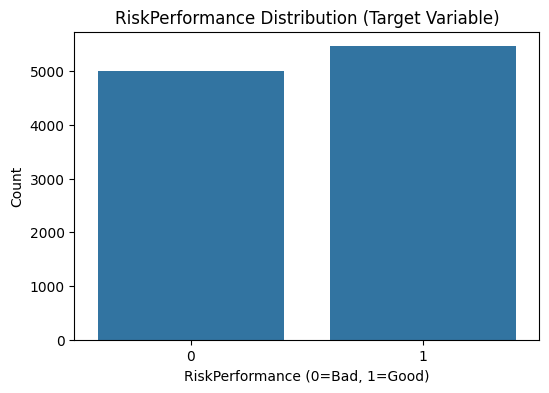

In [ ]:
### See if the data is balance
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned["RiskPerformance"])
plt.title("RiskPerformance Distribution (Target Variable)")
plt.xlabel("RiskPerformance (1=Bad, 0=Good)")
plt.ylabel("Count")
plt.show()

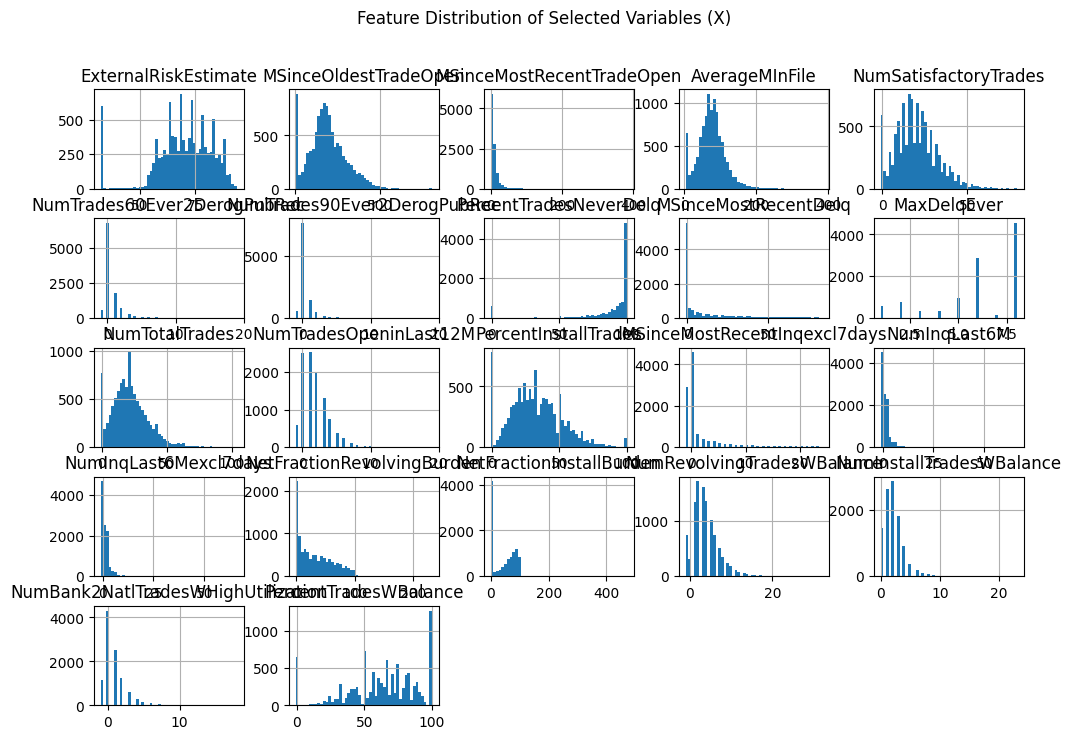

In [ ]:
## See the distribution of the variables
## Sounds skewed, not a great idea to do linear models
sample_columns = numerical_vars[:]
df_cleaned[sample_columns].hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature Distribution of Selected Variables (X)")
plt.show()

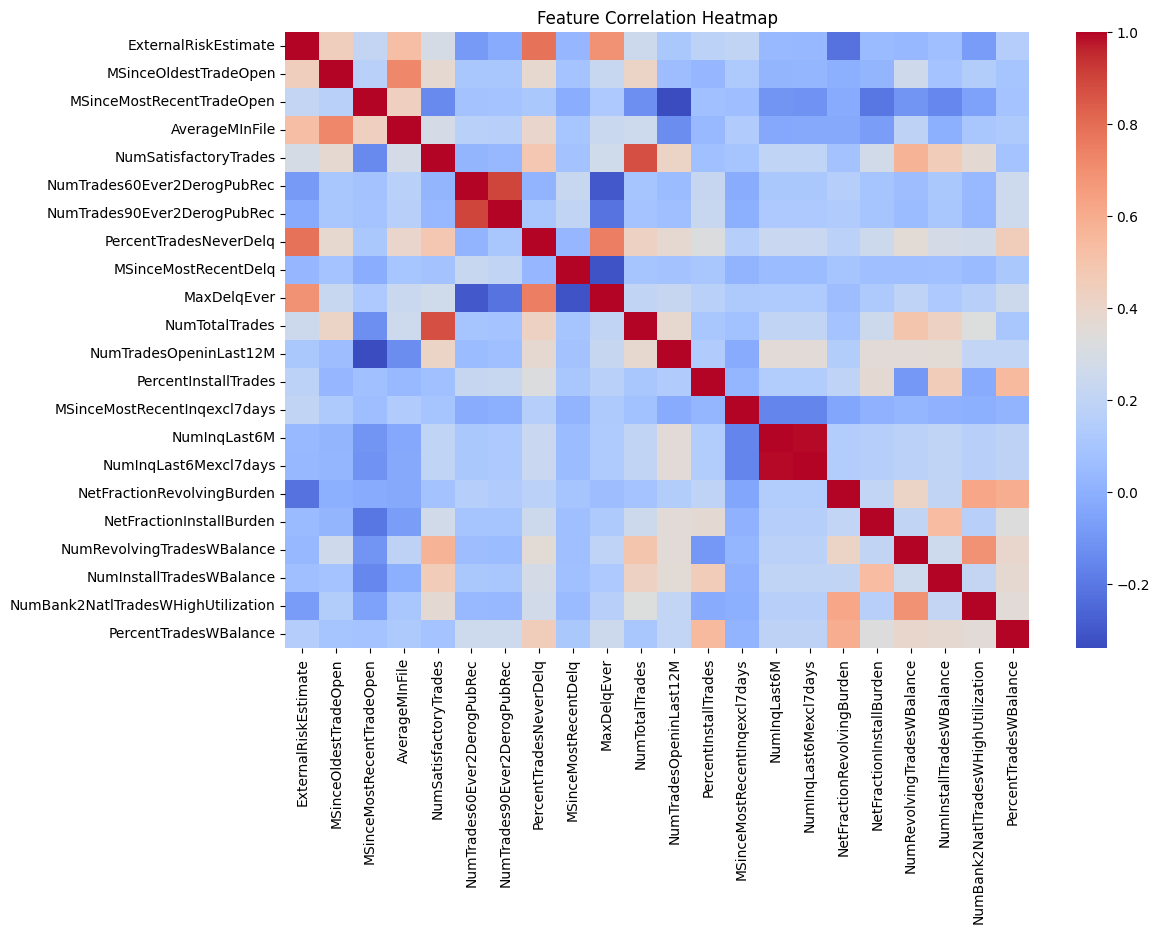

In [ ]:
# See the corrlation of the variables
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned[numerical_vars].corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


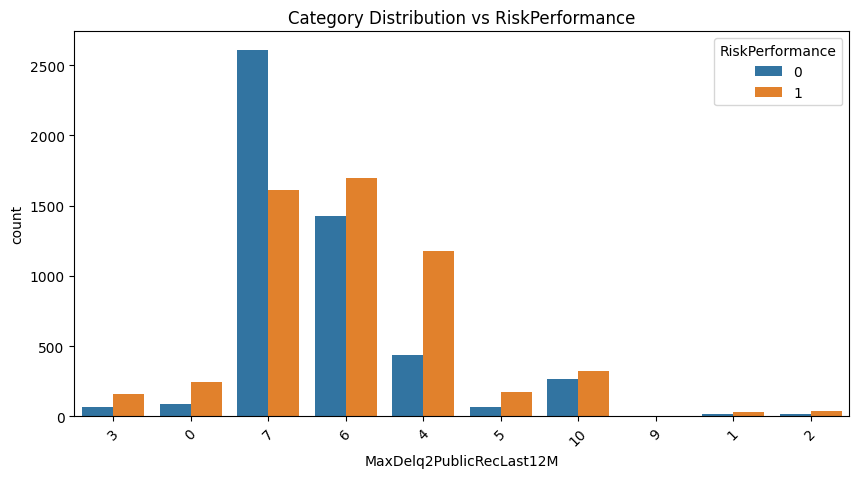

In [ ]:
## Categries and performance's relationship
plt.figure(figsize=(10, 5))
sns.countplot(data=df_cleaned, x="MaxDelq2PublicRecLast12M", hue="RiskPerformance")
plt.xticks(rotation=45)
plt.title("Category Distribution vs RiskPerformance")
plt.show()


In [ ]:
df_cleaned

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-1,8,1,1,69
1,1,61,58,15,41,2,4,4,100,-1,...,67,0,0,0,0,-1,0,0,-1,0
2,1,67,66,5,24,9,0,0,100,-1,...,44,0,4,4,53,66,4,2,1,86
3,1,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,1,81,333,27,132,12,0,0,100,-1,...,25,0,1,1,51,89,3,1,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,0,73,131,5,57,21,0,0,95,80,...,19,7,0,0,26,-1,5,2,0,100
10455,1,65,147,39,68,11,0,0,92,28,...,42,1,1,1,86,53,2,2,1,80
10456,1,74,129,6,64,18,1,1,100,-1,...,33,3,4,4,6,-1,5,0,0,56
10457,1,72,234,12,113,42,2,2,96,35,...,20,6,0,0,19,-1,4,1,0,38


In [ ]:
non_numeric_columns = df.columns[~df.applymap(lambda x: isinstance(x, (int, float))).all()]
print("non value col：", non_numeric_columns.tolist())

non value col： ['RiskPerformance']


<ipython-input-93-0a5b18be88e3>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = df.columns[~df.applymap(lambda x: isinstance(x, (int, float))).all()]


From the data we can know that the data is skewed, hard to use simple linear data. So we try to use some tree based data.

In [ ]:
# 80% training, 20% test
X = df_cleaned.drop(columns=["RiskPerformance"])
y = df_cleaned["RiskPerformance"]

X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f"training set: {X_train.shape[0]}, test set: {X_test.shape[0]}")

training set: 8367, test set: 2092


Try Rf (Tree based model)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, fbeta_score

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_f2 = fbeta_score(y_test, rf_preds, beta=2)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])


In [ ]:
print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")
print(f"F2-score: {rf_f2:.4f}")
print(f"AUC: {rf_auc:.4f}")


Random Forest Model Performance:
Accuracy: 0.7199
Recall: 0.7647
F1-score: 0.7402
F2-score: 0.7547
AUC: 0.7883


Optimize parameters for rf

In [ ]:
## grid use too much time, use bayesian optimization
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_categorical('max_depth', [10, 20, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])

    # train rf
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )


    scores = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='recall', n_jobs=-1)
    return scores.mean()



In [ ]:
from sklearn.model_selection import cross_val_score
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=20)

[I 2025-02-21 00:45:06,390] A new study created in memory with name: no-name-b25aacee-e4c5-4cdb-abd7-72c32a797beb
[I 2025-02-21 00:45:12,361] Trial 0 finished with value: 0.7744458290850044 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7744458290850044.
[I 2025-02-21 00:45:21,634] Trial 1 finished with value: 0.7760482358420503 and parameters: {'n_estimators': 369, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7760482358420503.
[I 2025-02-21 00:45:33,370] Trial 2 finished with value: 0.7820039210503128 and parameters: {'n_estimators': 381, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7820039210503128.
[I 2025-02-21 00:45:39,968] Trial 3 finished with value: 0.7774226489432675 and parameters: {'n_estimators': 282, 'max_de

In [ ]:
best_rf_params = rf_study.best_params
print("Best Random Forest Parameters:", best_rf_params)


Best Random Forest Parameters: {'n_estimators': 216, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'class_weight': 'balanced'}


In [ ]:
best_rf_model = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    class_weight=best_rf_params['class_weight'],
    random_state=42,
    n_jobs=-1
)

best_rf_model.fit(X_train, y_train)

rf_preds = best_rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_preds)
rf_recall = recall_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_f2 = fbeta_score(y_test, rf_preds, beta=2)
rf_auc = roc_auc_score(y_test, rf_preds)

In [ ]:
rf_results = pd.DataFrame({
    "Model": ["Optimized Random Forest"],
    "Accuracy": [rf_accuracy],
    "Recall": [rf_recall],
    "F1-score": [rf_f1],
    "F2-score": [rf_f2],
    "AUC": [rf_auc]
})

print("Optimized Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")
print(f"F2-score: {rf_f2:.4f}")
print(f"AUC: {rf_auc:.4f}")

Optimized Random Forest Model Performance:
Accuracy: 0.7199
Recall: 0.7766
F1-score: 0.7432
F2-score: 0.7629
AUC: 0.7173


Try GAM (Linear but allow unlinear funtions)

In [ ]:
!pip install pygam
gam = LogisticGAM().fit(X_train, y_train)
gam_preds = gam.predict(X_test)


In [ ]:
gam_accuracy = accuracy_score(y_test, gam_preds)
gam_report = classification_report(y_test, gam_preds)

print("GAM Accuracy:", gam_accuracy)
print("GAM Classification Report:")
print(gam_report)

GAM Accuracy: 0.7179732313575525
GAM Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1000
           1       0.72      0.75      0.74      1092

    accuracy                           0.72      2092
   macro avg       0.72      0.72      0.72      2092
weighted avg       0.72      0.72      0.72      2092



In [ ]:
from sklearn.metrics import fbeta_score
gam_probs = gam.predict_proba(X_test)
gam_preds_adjusted = (gam_probs > 0.5).astype(int)
f2_score = fbeta_score(y_test, gam_preds_adjusted, beta=2)

print(" GAM F2-score :", f2_score)

 GAM F2-score : 0.7459165154264973


Optimize parameters for GAM

In [ ]:
!pip install optuna


In [ ]:
### Also, use bayesian optimization
!pip install pygam
from pygam import LogisticGAM
from sklearn.model_selection import GridSearchCV
import numpy as np


In [ ]:
def gam_objective(trial):
    lam = trial.suggest_loguniform('lam', 1e-3, 1e3)
    n_splines = trial.suggest_categorical('n_splines', [5, 10, 20, 30])
    spline_order = trial.suggest_categorical('spline_order', [2, 3])
    max_iter = trial.suggest_categorical('max_iter', [100, 500, 1000])
    gam = LogisticGAM(lam=lam, n_splines=n_splines, spline_order=spline_order, max_iter=max_iter).fit(X_train, y_train)

    y_pred = gam.predict(X_test)
    recall = recall_score(y_test, y_pred)
    return recall

study = optuna.create_study(direction='maximize')
study.optimize(gam_objective, n_trials=20)



[I 2025-02-21 00:47:55,330] A new study created in memory with name: no-name-c8fad92f-4aec-4ad4-a111-886d85edfc9a
<ipython-input-45-91d749192f10>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lam = trial.suggest_loguniform('lam', 1e-3, 1e3)
[I 2025-02-21 00:48:36,376] Trial 0 finished with value: 0.7307692307692307 and parameters: {'lam': 0.09729500905552427, 'n_splines': 30, 'spline_order': 2, 'max_iter': 100}. Best is trial 0 with value: 0.7307692307692307.
<ipython-input-45-91d749192f10>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lam = trial.suggest_loguniform('lam', 1e-3, 1e3)
/usr/local/lib/python3.11/dist-packages/pygam/links.py:149: RuntimeWarning: divid

In [ ]:
print("Best GAM Parameters:", study.best_params)

Best GAM Parameters: {'lam': 1.7104343274928702, 'n_splines': 5, 'spline_order': 2, 'max_iter': 500}


In [ ]:
best_gam = LogisticGAM(
    lam=study.best_params['lam'],
    n_splines=study.best_params['n_splines'],
    spline_order=study.best_params['spline_order'],
    max_iter=study.best_params['max_iter']
).fit(X_train, y_train)

gam_preds = best_gam.predict(X_test)

gam_accuracy = accuracy_score(y_test, gam_preds)
gam_recall = recall_score(y_test, gam_preds)
gam_f1 = f1_score(y_test, gam_preds)
gam_f2 = fbeta_score(y_test, gam_preds, beta=2)
gam_auc = roc_auc_score(y_test, gam_preds)

gam_results = pd.DataFrame({
    "Model": ["Optimized GAM"],
    "Accuracy": [gam_accuracy],
    "Recall": [gam_recall],
    "F1-score": [gam_f1],
    "F2-score": [gam_f2],
    "AUC": [gam_auc]
})

print("Optimized GAM Model Performance:")
print(f"Accuracy: {gam_accuracy:.4f}")
print(f"Recall: {gam_recall:.4f}")
print(f"F1-score: {gam_f1:.4f}")
print(f"F2-score: {gam_f2:.4f}")
print(f"AUC: {gam_auc:.4f}")


Optimized GAM Model Performance:
Accuracy: 0.7228
Recall: 0.7683
F1-score: 0.7431
F2-score: 0.7580
AUC: 0.7207


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, roc_auc_score


NN needs standarised data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Try MLP (Deep Learning)

In [ ]:
def build_mlp():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
mlp_model = build_mlp()
history = mlp_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


262/262 - 3s - 11ms/step - accuracy: 0.6756 - loss: 0.6108 - val_accuracy: 0.7103 - val_loss: 0.5704
Epoch 2/100
262/262 - 1s - 5ms/step - accuracy: 0.7129 - loss: 0.5747 - val_accuracy: 0.7027 - val_loss: 0.5652
Epoch 3/100
262/262 - 1s - 4ms/step - accuracy: 0.7108 - loss: 0.5697 - val_accuracy: 0.7094 - val_loss: 0.5650
Epoch 4/100
262/262 - 1s - 4ms/step - accuracy: 0.7141 - loss: 0.5637 - val_accuracy: 0.7146 - val_loss: 0.5608
Epoch 5/100
262/262 - 1s - 3ms/step - accuracy: 0.7187 - loss: 0.5616 - val_accuracy: 0.7132 - val_loss: 0.5592
Epoch 6/100
262/262 - 1s - 5ms/step - accuracy: 0.7202 - loss: 0.5611 - val_accuracy: 0.7146 - val_loss: 0.5629
Epoch 7/100
262/262 - 1s - 3ms/step - accuracy: 0.7185 - loss: 0.5591 - val_accuracy: 0.7146 - val_loss: 0.5594
Epoch 8/100
262/262 - 1s - 3ms/step - accuracy: 0.7227 - loss: 0.5571 - val_accuracy: 0.7141 - val_loss: 0.5566
Epoch 9/100
262/262 - 1s - 3ms/step - accuracy: 0.7250 - loss: 0.5547 - val_accuracy: 0.7165 - val_loss: 0.5551
Epo

In [ ]:
mlp_preds = (mlp_model.predict(X_test_scaled) > 0.5).astype(int)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
mlp_accuracy = accuracy_score(y_test, mlp_preds)
mlp_recall = recall_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_f2 = fbeta_score(y_test, mlp_preds, beta=2)
mlp_auc = roc_auc_score(y_test, mlp_preds)


In [ ]:
mlp_results = pd.DataFrame({
    "Model": ["MLP Neural Network"],
    "Accuracy": [mlp_accuracy],
    "Recall": [mlp_recall],
    "F1-score": [mlp_f1],
    "F2-score": [mlp_f2],
    "AUC": [mlp_auc]
})


print("MLP Neural Network Performance:")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1-score: {mlp_f1:.4f}")
print(f"F2-score: {mlp_f2:.4f}")
print(f"AUC: {mlp_auc:.4f}")


MLP Neural Network Performance:
Accuracy: 0.7165
Recall: 0.7985
F1-score: 0.7463
F2-score: 0.7768
AUC: 0.7128


In [ ]:
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import recall_score, fbeta_score
import keras.backend as K

In [ ]:
def f2_loss(y_true, y_pred):
    beta = 2
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + tf.keras.backend.epsilon())
    return 1 - f2

def mlp_objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    neurons = [trial.suggest_int(f"n_units_l{i}", 32, 256) for i in range(n_layers)]

    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)

    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = Sequential()
    model.add(Dense(neurons[0], activation="relu", input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(dropout_rate))

    for i in range(1, n_layers):
        model.add(Dense(neurons[i], activation="relu"))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=f2_loss, metrics=["accuracy"])

    model.fit(X_train_scaled, y_train, epochs=50, batch_size=batch_size, verbose=0, validation_data=(X_test_scaled, y_test))

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    return f2

study = optuna.create_study(direction="maximize")
study.optimize(mlp_objective, n_trials=20)

best_mlp_params = study.best_params
print("Best MLP Parameters:", best_mlp_params)


[I 2025-02-21 01:26:38,291] A new study created in memory with name: no-name-4aa59afc-121c-495d-b0bd-fbfb62a592d4
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:26:56,795] Trial 0 finished with value: 0.8468790637191157 and parameters: {'n_layers': 1, 'n_units_l0': 61, 'dropout_rate': 0.2921432200787318, 'learning_rate': 0.004881128011064404, 'batch_size': 128}. Best is trial 0 with value: 0.8468790637191157.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` a

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:27:16,120] Trial 1 finished with value: 0.8488278092158448 and parameters: {'n_layers': 2, 'n_units_l0': 244, 'n_units_l1': 35, 'dropout_rate': 0.4548255033699017, 'learning_rate': 0.0005493054380531295, 'batch_size': 128}. Best is trial 1 with value: 0.8488278092158448.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:27:47,552] Trial 2 finished with value: 0.8475120385232745 and parameters: {'n_layers': 1, 'n_units_l0': 227, 'dropout_rate': 0.47345944874272516, 'learning_rate': 0.0024326238151743972, 'batch_size': 64}. Best is trial 1 with value: 0.8488278092158448.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim`

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:28:41,110] Trial 3 finished with value: 0.8428899082568807 and parameters: {'n_layers': 1, 'n_units_l0': 121, 'dropout_rate': 0.3242589075260337, 'learning_rate': 0.005085333277624042, 'batch_size': 32}. Best is trial 1 with value: 0.8488278092158448.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` a

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:29:42,880] Trial 4 finished with value: 0.8523925385239254 and parameters: {'n_layers': 3, 'n_units_l0': 236, 'n_units_l1': 118, 'n_units_l2': 34, 'dropout_rate': 0.4302952349665329, 'learning_rate': 0.0004992660937593537, 'batch_size': 32}. Best is trial 4 with value: 0.8523925385239254.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do n

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:30:04,544] Trial 5 finished with value: 0.8452012383900929 and parameters: {'n_layers': 3, 'n_units_l0': 115, 'n_units_l1': 89, 'n_units_l2': 39, 'dropout_rate': 0.4708961224671465, 'learning_rate': 0.00012510066791818049, 'batch_size': 128}. Best is trial 4 with value: 0.8523925385239254.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do 

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:31:01,880] Trial 6 finished with value: 0.8452012383900929 and parameters: {'n_layers': 3, 'n_units_l0': 117, 'n_units_l1': 166, 'n_units_l2': 47, 'dropout_rate': 0.13378432526630496, 'learning_rate': 0.0022549051908898827, 'batch_size': 32}. Best is trial 4 with value: 0.8523925385239254.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do 

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:32:05,947] Trial 7 finished with value: 0.8452012383900929 and parameters: {'n_layers': 3, 'n_units_l0': 72, 'n_units_l1': 238, 'n_units_l2': 171, 'dropout_rate': 0.22911612364973039, 'learning_rate': 0.005929559657761825, 'batch_size': 32}. Best is trial 4 with value: 0.8523925385239254.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do n

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:32:35,420] Trial 8 finished with value: 0.8544906378927325 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'dropout_rate': 0.16814266273528095, 'learning_rate': 0.00010720532489755787, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim`

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:33:33,191] Trial 9 finished with value: 0.8523908523908524 and parameters: {'n_layers': 2, 'n_units_l0': 59, 'n_units_l1': 64, 'dropout_rate': 0.346307684512816, 'learning_rate': 0.004840507441103065, 'batch_size': 32}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shap

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:34:01,750] Trial 10 finished with value: 0.8527813299232737 and parameters: {'n_layers': 1, 'n_units_l0': 182, 'dropout_rate': 0.10156253300495383, 'learning_rate': 0.00011495736799085848, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_di

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-02-21 01:34:30,643] Trial 11 finished with value: 0.8527440970006381 and parameters: {'n_layers': 1, 'n_units_l0': 179, 'dropout_rate': 0.10136437757468808, 'learning_rate': 0.00010224546755675835, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_di

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:35:06,194] Trial 12 finished with value: 0.8489499192245558 and parameters: {'n_layers': 2, 'n_units_l0': 173, 'n_units_l1': 256, 'dropout_rate': 0.17736474755257509, 'learning_rate': 0.0002702859850542748, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `inpu

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:35:36,311] Trial 13 finished with value: 0.851029601029601 and parameters: {'n_layers': 1, 'n_units_l0': 186, 'dropout_rate': 0.19427019741617008, 'learning_rate': 0.0002274521660119701, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim`

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:36:03,254] Trial 14 finished with value: 0.8538914531274868 and parameters: {'n_layers': 1, 'n_units_l0': 36, 'dropout_rate': 0.2431752007061107, 'learning_rate': 0.0002072356743153253, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` 

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-02-21 01:36:34,191] Trial 15 finished with value: 0.8452012383900929 and parameters: {'n_layers': 2, 'n_units_l0': 33, 'n_units_l1': 185, 'dropout_rate': 0.2510789444580427, 'learning_rate': 0.0002467255994986087, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:37:01,918] Trial 16 finished with value: 0.8532886334610472 and parameters: {'n_layers': 1, 'n_units_l0': 33, 'dropout_rate': 0.3843848884645219, 'learning_rate': 0.0007108589762151829, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` 

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-02-21 01:37:37,120] Trial 17 finished with value: 0.8507895584917822 and parameters: {'n_layers': 2, 'n_units_l0': 91, 'n_units_l1': 209, 'dropout_rate': 0.2678793511177302, 'learning_rate': 0.0011989265296330912, 'batch_size': 64}. Best is trial 8 with value: 0.8544906378927325.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-02-21 01:38:06,919] Trial 18 finished with value: 0.8552 and parameters: {'n_layers': 1, 'n_units_l0': 82, 'dropout_rate': 0.182328903651398, 'learning_rate': 0.00018181752827685244, 'batch_size': 64}. Best is trial 18 with value: 0.8552.
<ipython-input-77-309cda5eb45b>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-77-309cda5eb45b>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. Wh

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-02-21 01:38:36,669] Trial 19 finished with value: 0.8528187059577194 and parameters: {'n_layers': 1, 'n_units_l0': 93, 'dropout_rate': 0.17625830463029973, 'learning_rate': 0.0003416377537991522, 'batch_size': 64}. Best is trial 18 with value: 0.8552.


Best MLP Parameters: {'n_layers': 1, 'n_units_l0': 82, 'dropout_rate': 0.182328903651398, 'learning_rate': 0.00018181752827685244, 'batch_size': 64}


In [ ]:
best_layers = best_mlp_params["n_layers"]
best_neurons = [best_mlp_params[f"n_units_l{i}"] for i in range(best_layers)]
best_dropout = best_mlp_params["dropout_rate"]
best_lr = best_mlp_params["learning_rate"]
best_batch_size = best_mlp_params["batch_size"]

best_mlp_model = Sequential()
best_mlp_model.add(Dense(best_neurons[0], activation="relu", input_shape=(X_train_scaled.shape[1],)))
best_mlp_model.add(Dropout(best_dropout))

for i in range(1, best_layers):
    best_mlp_model.add(Dense(best_neurons[i], activation="relu"))
    best_mlp_model.add(Dropout(best_dropout))

best_mlp_model.add(Dense(1, activation="sigmoid"))

best_mlp_model.compile(optimizer=Adam(learning_rate=best_lr), loss=f2_loss, metrics=["accuracy"])

best_mlp_model.fit(X_train_scaled, y_train, epochs=100, batch_size=best_batch_size, verbose=2, validation_data=(X_test_scaled, y_test))


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 - 2s - 14ms/step - accuracy: 0.5218 - loss: 0.4092 - val_accuracy: 0.5368 - val_loss: 0.3194
Epoch 2/100
131/131 - 0s - 3ms/step - accuracy: 0.5482 - loss: 0.2763 - val_accuracy: 0.5354 - val_loss: 0.2410
Epoch 3/100
131/131 - 1s - 5ms/step - accuracy: 0.5362 - loss: 0.2234 - val_accuracy: 0.5272 - val_loss: 0.2085
Epoch 4/100
131/131 - 1s - 4ms/step - accuracy: 0.5285 - loss: 0.2000 - val_accuracy: 0.5234 - val_loss: 0.1917
Epoch 5/100
131/131 - 0s - 3ms/step - accuracy: 0.5258 - loss: 0.1863 - val_accuracy: 0.5229 - val_loss: 0.1819
Epoch 6/100
131/131 - 1s - 5ms/step - accuracy: 0.5248 - loss: 0.1785 - val_accuracy: 0.5220 - val_loss: 0.1756
Epoch 7/100
131/131 - 1s - 5ms/step - accuracy: 0.5237 - loss: 0.1728 - val_accuracy: 0.5220 - val_loss: 0.1713
Epoch 8/100
131/131 - 1s - 5ms/step - accuracy: 0.5237 - loss: 0.1683 - val_accuracy: 0.5220 - val_loss: 0.1683
Epoch 9/100
131/131 - 1s - 4ms/step - accuracy: 0.5236 - loss: 0.1672 - val_accuracy: 0.5220 - val_loss: 0.1659
Epo

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, roc_auc_score

mlp_preds = (best_mlp_model.predict(X_test_scaled) > 0.5).astype(int)

mlp_accuracy = accuracy_score(y_test, mlp_preds)
mlp_recall = recall_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_f2 = fbeta_score(y_test, mlp_preds, beta=2)
mlp_auc = roc_auc_score(y_test, mlp_preds)

print("Optimized MLP Model Performance:")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1-score: {mlp_f1:.4f}")
print(f"F2-score: {mlp_f2:.4f}")
print(f"AUC: {mlp_auc:.4f}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Optimized MLP Model Performance:
Accuracy: 0.6033
Recall: 0.9725
F1-score: 0.7190
F2-score: 0.8523
AUC: 0.5863


Comparing these models, we choose MLP. Due to it's highest F2-score.

PermutationExplainer explainer: 2093it [04:09,  8.37it/s]


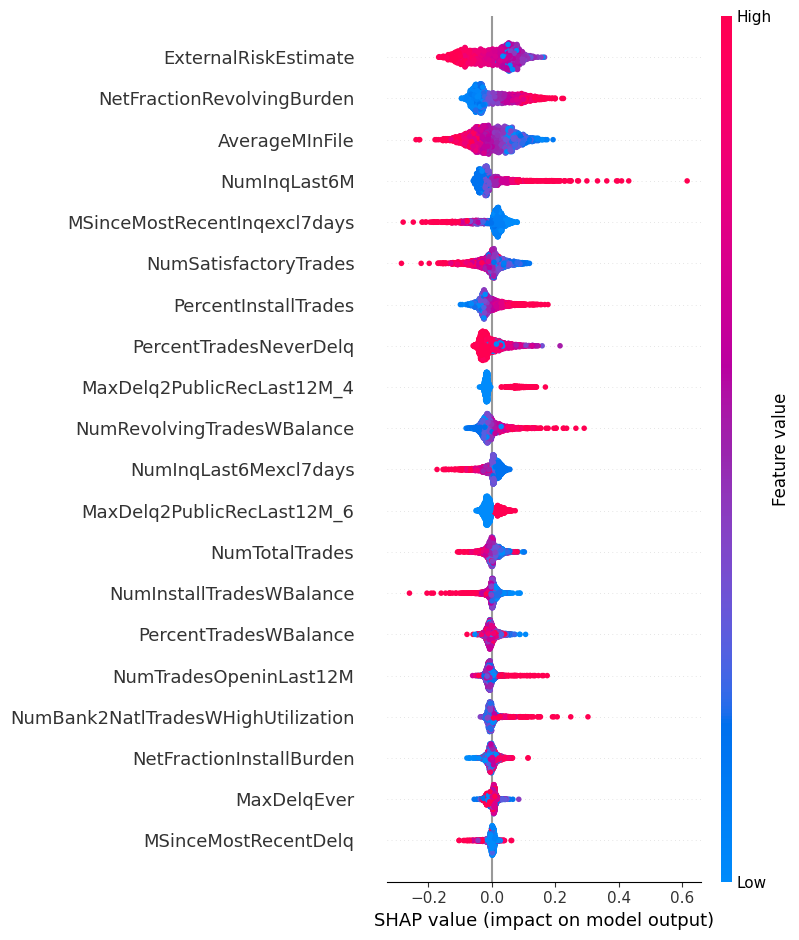

In [ ]:
import shap
## find the feature importance
explainer = shap.Explainer(mlp_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

In [ ]:
shap_df = pd.DataFrame(shap_values.values, columns=X_train.columns)
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
shap_direction = shap_df.mean().sort_values(ascending=False)
shap_analysis = pd.DataFrame({
    "Feature": shap_importance.index,
    "Mean Absolute SHAP": shap_importance.values,
    "Mean SHAP Direction": shap_direction[shap_importance.index].values
})


In [ ]:
shap_analysis.head(10)

,Feature,Mean Absolute SHAP,Mean SHAP Direction
0,ExternalRiskEstimate,0.059585,0.001037
1,NetFractionRevolvingBurden,0.053242,0.007121
2,AverageMInFile,0.049819,0.002172
3,NumInqLast6M,0.035802,-0.001691
4,MSinceMostRecentInqexcl7days,0.034110,0.001248
5,NumSatisfactoryTrades,0.031665,-0.003797
6,PercentInstallTrades,0.028807,-0.004368
7,PercentTradesNeverDelq,0.027765,-0.002776
8,MaxDelq2PublicRecLast12M_4,0.027109,-0.001292
9,NumRevolvingTradesWBalance,0.024268,-0.001047


In [ ]:
pass_X_mean=(1,2,6,3,7,2),
X_new=(-1,4,6,4,1,5)
0，1 rej --- X_new  VS  Pass_avg
数据avg，全 y=0.98x1+0.24x2+0.01x3_0.34x4+0.003X5

In [ ]:
pass_X_mean()(performance=0)

NameError: name 'X_mean' is not defined